In [160]:
import pandas as pd
#from sklearn import datasets # sklearn comes with some toy datasets to practise
#from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
#from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [161]:
songs_df=pd.read_csv(r'.\data\not_top100.csv')

In [162]:
def kmeans_clustering(audio_features_df, num_clusters, audio_feature_columns):
    # Select the columns for clustering
    data = audio_features_df[audio_feature_columns]

    # Create a K-Means model
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)

    # Fit the K-Means model to the data
    kmeans.fit(data)

    # Assign cluster labels to the original DataFrame
    audio_features_df['cluster_label'] = kmeans.labels_

    # Calculate the Calinski-Harabasz score
    calinski_score = calinski_harabasz_score(data, kmeans.labels_)

    return audio_features_df, calinski_score


In [188]:

def cluster_audio_features(audio_features_df, audio_feature_columns, num_clusters):
    # Select the columns for clustering, excluding 'uri' and 'song_name'
    data = audio_features_df[audio_feature_columns]

    # Create a K-Means model
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)

    # Fit the K-Means model to the data
    kmeans.fit(data)

    # Assign cluster labels to the original DataFrame
    audio_features_df['cluster_label'] = kmeans.labels_

    return audio_features_df

def build_recommendation_model(clustered_df):
    # Create a k-NN model, excluding 'uri' and 'song_name'
    knn = NearestNeighbors(n_neighbors=4, metric='euclidean', n_jobs=-1)

    # Fit the k-NN model to the clustered data, excluding 'uri' and 'song_name'
    knn.fit(clustered_df[clustered_df.columns.difference(['uri', 'song_name', 'cluster_label'])])

    return knn

def song_recommender(clustered_df, recommendation_model, songs, num_recommendations=3):
    song_clusters = []
    for _, song in songs.iterrows():
        song_uri = song['uri']
        song_data = clustered_df[clustered_df['uri'] == song_uri]
        if not song_data.empty:
            cluster = int(song_data['cluster_label'].iloc[0])
            song_clusters.append(cluster)

    recommendations = []
    for cluster in song_clusters:
        cluster_songs = clustered_df[clustered_df['cluster_label'] == cluster]

        if len(cluster_songs) > num_recommendations:
            cluster_data = cluster_songs[clustered_df.columns.difference(['uri', 'song_name', 'cluster_label'])]
            indices = recommendation_model.kneighbors(cluster_data, num_recommendations + 1, return_distance=False)

            added_recommendations = 0
            for index in indices[0][1:]:
                if added_recommendations >= num_recommendations:
                    break
                if index < len(cluster_songs):
                    recommendations.append(cluster_songs.iloc[index]['uri'])
                    added_recommendations += 1

    return recommendations


def calculate_recommendation_score(recommendations, audio_features_df):
    recommendation_scores = []

    for uri in recommendations:
        # Find the song data in the audio_features_df
        song_data = audio_features_df[audio_features_df['uri'] == uri]

        # Calculate a score based on audio features (e.g., the mean of specific features)
        if not song_data.empty:
            # Customize the scoring function based on your preferences
            score = (song_data['danceability'] + song_data['energy']) / 2.0
            recommendation_scores.append((uri, score))

    # Sort the recommendations by score in descending order
    recommendation_scores.sort(key=lambda x: x[1], reverse=True)

    return recommendation_scores

def song_recommender_with_scores(clustered_df, recommendation_model, songs, audio_features_df, num_recommendations=3):
    song_clusters = []
    for _, song in songs.iterrows():
        song_uri = song['uri']
        song_data = clustered_df[clustered_df['uri'] == song_uri]
        if not song_data.empty:
            cluster = int(song_data['cluster_label'].iloc[0])
            song_clusters.append(cluster)

    recommendations = []
    for cluster in song_clusters:
        cluster_songs = clustered_df[clustered_df['cluster_label'] == cluster]

        if len(cluster_songs) > num_recommendations:
            cluster_data = cluster_songs[clustered_df.columns.difference(['uri', 'song_name', 'cluster_label'])]
            indices = recommendation_model.kneighbors(cluster_data, num_recommendations + 1, return_distance=False)

            added_recommendations = 0
            for index in indices[0][1:]:
                if added_recommendations >= num_recommendations:
                    break
                if index < len(cluster_songs):
                    recommendations.append(cluster_songs.iloc[index]['uri'])
                    added_recommendations += 1

    # Calculate scores for recommendations
    recommendation_scores = calculate_recommendation_score(recommendations, audio_features_df)

    return recommendation_scores


def drop_columns(dataframe, columns_to_drop):
    """
    Drops specified columns from a DataFrame.
    
    Parameters:
        dataframe (pandas.DataFrame): The DataFrame from which columns should be dropped.
        columns_to_drop (list): List of column names to drop from the DataFrame.

    Returns:
        pandas.DataFrame: A new DataFrame with the specified columns dropped.
    """
    return dataframe.drop(columns=columns_to_drop)

import requests

def get_spotify_url_from_uri(spotify_uri, access_token):
    # Define the Spotify API endpoint for track information
    endpoint = f'https://api.spotify.com/v1/tracks/{spotify_uri.split(":")[-1]}'

    # Set up the headers with the access token
    headers = {
        'Authorization': f'Bearer {access_token}'
    }

    try:
        # Make a GET request to the Spotify API
        response = requests.get(endpoint, headers=headers)

        if response.status_code == 200:
            # Parse the JSON response
            track_data = response.json()

            # Extract the external URL (Spotify URL) from the track data
            spotify_url = track_data.get('external_urls', {}).get('spotify')
            return spotify_url
        else:
            print(f"Failed to retrieve data. Status code: {response.status_code}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

    return None




In [172]:
songs_df.drop_duplicates(subset='uri', keep='first', inplace=True)

songs_df = songs_df.reset_index(drop=True)

In [173]:
# Perform Label Encoding on the 'genre' column

from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to the 'genre' column
songs_df['genre_enc'] = label_encoder.fit_transform(songs_df['genre'])
songs_df

,song_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,hot,cluster_label,genre_enc
0,Mercury: Retrograde,0.831,0.814,2,-7.364,1,0.4200,0.05980,0.013400,0.0556,...,2Vc6NJ9PW9gD9q343XFRKx,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...,https://api.spotify.com/v1/audio-analysis/2Vc6...,124539,4,Dark Trap,N,1,0
1,Pathology,0.719,0.493,8,-7.230,1,0.0794,0.40100,0.000000,0.1180,...,7pgJBLVz5VmnL7uGHmRj6p,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...,https://api.spotify.com/v1/audio-analysis/7pgJ...,224427,4,Dark Trap,N,0,0
2,Symbiote,0.850,0.893,5,-4.783,1,0.0623,0.01380,0.000004,0.3720,...,0vSWgAlfpye0WCGeNmuNhy,spotify:track:0vSWgAlfpye0WCGeNmuNhy,https://api.spotify.com/v1/tracks/0vSWgAlfpye0...,https://api.spotify.com/v1/audio-analysis/0vSW...,98821,4,Dark Trap,N,1,0
3,ProductOfDrugs (Prod. The Virus and Antidote),0.476,0.781,0,-4.710,1,0.1030,0.02370,0.000000,0.1140,...,0VSXnJqQkwuH2ei1nOQ1nu,spotify:track:0VSXnJqQkwuH2ei1nOQ1nu,https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...,https://api.spotify.com/v1/audio-analysis/0VSX...,123661,3,Dark Trap,N,2,0
4,Venom,0.798,0.624,2,-7.668,1,0.2930,0.21700,0.000000,0.1660,...,4jCeguq9rMTlbMmPHuO7S3,spotify:track:4jCeguq9rMTlbMmPHuO7S3,https://api.spotify.com/v1/tracks/4jCeguq9rMTl...,https://api.spotify.com/v1/audio-analysis/4jCe...,123298,4,Dark Trap,N,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18321,"H20 (feat. Pharoahe Monch, Rakaa Iriscience, &...",0.526,0.819,7,-6.728,1,0.2980,0.00206,0.000003,0.3360,...,54v6Kv41W8AKToCb14PmJD,spotify:track:54v6Kv41W8AKToCb14PmJD,https://api.spotify.com/v1/tracks/54v6Kv41W8AK...,https://api.spotify.com/v1/audio-analysis/54v6...,281886,4,Hiphop,N,2,2
18322,Daddy's Girl,0.538,0.819,1,-6.780,1,0.4670,0.00854,0.000000,0.1310,...,4YuGxSdxyL6fRD7uchn9dI,spotify:track:4YuGxSdxyL6fRD7uchn9dI,https://api.spotify.com/v1/tracks/4YuGxSdxyL6f...,https://api.spotify.com/v1/audio-analysis/4YuG...,209582,4,Hiphop,N,2,2
18323,'94,0.415,0.548,7,-8.563,1,0.2850,0.22400,0.000000,0.1220,...,034dSXepspHaYFW7rZZx1d,spotify:track:034dSXepspHaYFW7rZZx1d,https://api.spotify.com/v1/tracks/034dSXepspHa...,https://api.spotify.com/v1/audio-analysis/034d...,213898,4,Hiphop,N,2,2
18324,Born 2 Live,0.785,0.648,7,-6.907,1,0.2790,0.01570,0.001980,0.1000,...,7oCZpPJcPDZfeIy2t6gqSg,spotify:track:7oCZpPJcPDZfeIy2t6gqSg,https://api.spotify.com/v1/tracks/7oCZpPJcPDZf...,https://api.spotify.com/v1/audio-analysis/7oCZ...,271867,4,Hiphop,N,1,2


In [165]:
# Assuming audio_features_df is your audio features DataFrame and audio_feature_columns is a list of column names for clustering.
num_clusters = 3  # Set the number of clusters you want
audio_feature_columns=["danceability","energy"]
#audio_feature_columns=["danceability","tempo"]
clustered_df, calinski_score = kmeans_clustering(songs_df, num_clusters, audio_feature_columns)

C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be

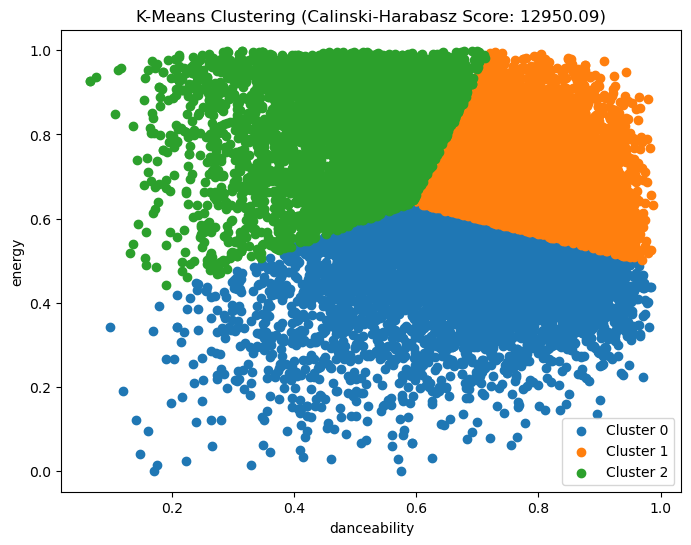

In [174]:
# Plotting the clusters
plt.figure(figsize=(8, 6))

for cluster_label in range(num_clusters):
    cluster_data = clustered_df[clustered_df['cluster_label'] == cluster_label]
    plt.scatter(cluster_data[audio_feature_columns[0]], cluster_data[audio_feature_columns[1]], label=f'Cluster {cluster_label}')

plt.title(f'K-Means Clustering (Calinski-Harabasz Score: {calinski_score:.2f})')
plt.xlabel(audio_feature_columns[0])
plt.ylabel(audio_feature_columns[1])
plt.legend()
plt.show()

In [175]:
num_clusters = 3  # Set the number of clusters you want
#audio_feature_columns=["danceability","energy"]
audio_feature_columns=["danceability","genre_enc"]
clustered_df, calinski_score = kmeans_clustering(songs_df, num_clusters, audio_feature_columns)

C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be

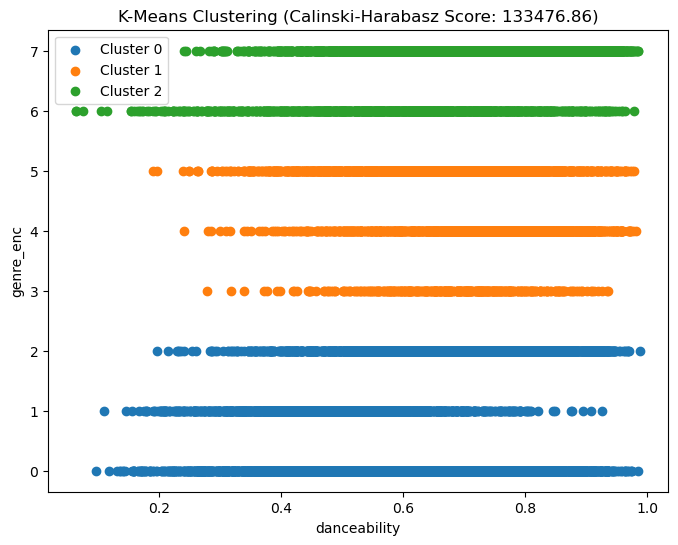

In [176]:
# Plotting the clusters
plt.figure(figsize=(8, 6))

for cluster_label in range(num_clusters):
    cluster_data = clustered_df[clustered_df['cluster_label'] == cluster_label]
    plt.scatter(cluster_data[audio_feature_columns[0]], cluster_data[audio_feature_columns[1]], label=f'Cluster {cluster_label}')

plt.title(f'K-Means Clustering (Calinski-Harabasz Score: {calinski_score:.2f})')
plt.xlabel(audio_feature_columns[0])
plt.ylabel(audio_feature_columns[1])
plt.legend()
plt.show()

Recommender

In [187]:
songs=songs_df.sample(n=5, random_state=100)
columns_to_remove = ["id","track_href","analysis_url","duration_ms","time_signature", "hot", "genre","type"]

songs_df_dropped = drop_columns(songs_df, columns_to_remove)
songs_4model = drop_columns(songs, columns_to_remove)
display(songs_4model)
print(songs[songs["uri"]==songs_4model["uri"]])

for uri in songs_4model["uri"]:
    spotify_uri = 'spotify:track:7oMFpfiP2K4frK1rhjMC2H'  # Replace with your URI
    access_token = 'your_access_token'  # Replace with your Spotify access token

spotify_url = get_spotify_url_from_uri(spotify_uri, access_token)

if spotify_url:
    print(f'Spotify URL: {spotify_url}')
else:
    print('Failed to retrieve the Spotify URL.')

,song_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,uri,cluster_label,genre_enc
16138,Friendly,0.577,0.848,0,-5.283,1,0.0541,0.25700,0.000000,0.1510,0.589,166.043,spotify:track:0F5Z02MUi7okP3O3IDUPUr,0,2
8029,Head Tap,0.798,0.641,1,-5.581,1,0.3720,0.46800,0.000000,0.1710,0.421,146.078,spotify:track:1snMZcKWW9QIeCEBafnqVx,2,7
5600,STRONG (feat. Lil Poppa),0.728,0.505,8,-6.361,1,0.1850,0.73100,0.000000,0.1070,0.646,155.082,spotify:track:1BZKLxEdjvpjehhIDM9y8o,2,7
17161,Monkey Suite,0.503,0.576,6,-9.227,0,0.3880,0.13700,0.000000,0.1450,0.862,186.826,spotify:track:6l3Bcu6R6Nx3h25l87gV5c,0,2
10624,Fear!,0.249,0.909,8,-1.078,1,0.0888,0.00957,0.000004,0.0797,0.150,115.304,spotify:track:1UC56OxGPJfL6b0V6Uocmj,2,6


                      song_name  danceability  energy  key  loudness  mode  \
16138                  Friendly         0.577   0.848    0    -5.283     1   
8029                   Head Tap         0.798   0.641    1    -5.581     1   
5600   STRONG (feat. Lil Poppa)         0.728   0.505    8    -6.361     1   
17161              Monkey Suite         0.503   0.576    6    -9.227     0   
10624                     Fear!         0.249   0.909    8    -1.078     1   

       speechiness  acousticness  instrumentalness  liveness  ...  \
16138       0.0541       0.25700          0.000000    0.1510  ...   
8029        0.3720       0.46800          0.000000    0.1710  ...   
5600        0.1850       0.73100          0.000000    0.1070  ...   
17161       0.3880       0.13700          0.000000    0.1450  ...   
10624       0.0888       0.00957          0.000004    0.0797  ...   

                           id                                   uri  \
16138  0F5Z02MUi7okP3O3IDUPUr  spotify:track:

In [183]:
# Example usage:
# Assuming audio_features_df is your audio features DataFrame
# songs is a list of 3-5 songs with their audio features
# Choose the number of clusters for audio feature pairs
num_clusters = 5
audio_feature_columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'genre_enc']

# Perform clustering
clustered_df = cluster_audio_features(songs_df_dropped, audio_feature_columns, num_clusters)

# Build a recommendation model
recommendation_model = build_recommendation_model(clustered_df)

# Recommend songs
recommendations = song_recommender(clustered_df, recommendation_model, songs_4model)
print(recommendations)

C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be

['spotify:track:3k8AeDhApZrHMeGGvtL3ev', 'spotify:track:5Xl4jZQFPGElFil9HDkb04', 'spotify:track:7b6Lp3fS8KjHY7LSxX5eCF', 'spotify:track:5Xl4jZQFPGElFil9HDkb04']


C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\i.glavatskyi\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [184]:
# Example usage:
recommended_songs_df = find_songs_by_uris(songs_df, recommendations)
recommended_songs_df.shape

(3, 23)

In [185]:
recommended_songs_df

,song_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,hot,cluster_label,genre_enc
910,Hourglass,0.849,0.407,3,-9.494,0,0.2400,0.0163,0.0960,0.127,...,3k8AeDhApZrHMeGGvtL3ev,spotify:track:3k8AeDhApZrHMeGGvtL3ev,https://api.spotify.com/v1/tracks/3k8AeDhApZrH...,https://api.spotify.com/v1/audio-analysis/3k8A...,143000,4,Dark Trap,N,0,0
6923,Wulf of Akina,0.653,0.426,2,-13.608,1,0.0398,0.4140,0.0631,0.050,...,7b6Lp3fS8KjHY7LSxX5eCF,spotify:track:7b6Lp3fS8KjHY7LSxX5eCF,https://api.spotify.com/v1/tracks/7b6Lp3fS8KjH...,https://api.spotify.com/v1/audio-analysis/7b6L...,189832,3,Underground Rap,N,2,7
15275,Cheers (Drink To That),0.582,0.903,9,-3.550,1,0.0404,0.0182,0.0000,0.297,...,5Xl4jZQFPGElFil9HDkb04,spotify:track:5Xl4jZQFPGElFil9HDkb04,https://api.spotify.com/v1/tracks/5Xl4jZQFPGEl...,https://api.spotify.com/v1/audio-analysis/5Xl4...,261747,4,RnB,N,1,5


In [146]:
# Example usage:
#recommendation_scores = song_recommender_with_scores(clustered_df, recommendation_model, songs_4model, audio_features_df, num_recommendations=5)
#print(recommendation_scores)

In [ ]:
answer=Yes
while